In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler



## Load the Data and split in Train and Test Datasets

In [14]:
df_final = pd.read_excel('Final Dataset.xlsx', sheet_name='data')

features = df_final[['n_pores', 'median_log_pores', 'n_agg', 'median_log_agg', 'r', 'g', 'b']]
img_name = df_final.iloc[:,1:2]

spec = df_final.iloc[:,0:1]
spec = spec.replace({'in-spec':1, 'out-of-spec':0})


f_tr, f_te, c_tr, c_te = train_test_split(
    features, spec, test_size=0.3, stratify=spec, random_state=1)

# # We split the train set in train and validate
f_tr, f_va, c_tr, c_va = train_test_split(
    f_tr, c_tr, test_size=0.1,stratify=c_tr, random_state=1)

In [3]:
# Define the set of values we will iterate
k_values = np.arange(1, 100,5) 
d_types = [1,2] # L1 and L2 distance


# Accuracy on the train/test sets
# Save accuracy on test set
scores = [] 

for k in k_values:
    for d in d_types:
        # Set k & p
        pipe = Pipeline([
#             ('scaler', StandardScaler()),
            ('scaler', MinMaxScaler()), #We use the Min Max given for the RGB feature it might not be the best
            ('knn', KNeighborsClassifier())
        ])
        pipe.set_params(knn__n_neighbors = k, knn__p = d)
        # Fit k-NN
        pipe.fit(f_tr, c_tr)
        score = {}
        score['n neighbors'] = k
        score['distance metric'] = d
        score['validation accuracy (validation set)'] = pipe.score(f_va, c_va)
        score['validation accuracy (training set)'] = pipe.score(f_tr, c_tr)
        scores.append(score)
        
scores_df = pd.DataFrame(scores)
scores_df.head(5)

,n neighbors,distance metric,validation accuracy (validation set),validation accuracy (training set)
0,1,1,0.771429,1.000000
1,1,2,0.771429,1.000000
2,6,1,0.771429,0.859935
3,6,2,0.771429,0.872964
4,11,1,0.771429,0.846906


## Plot the train and Validation accuracy 

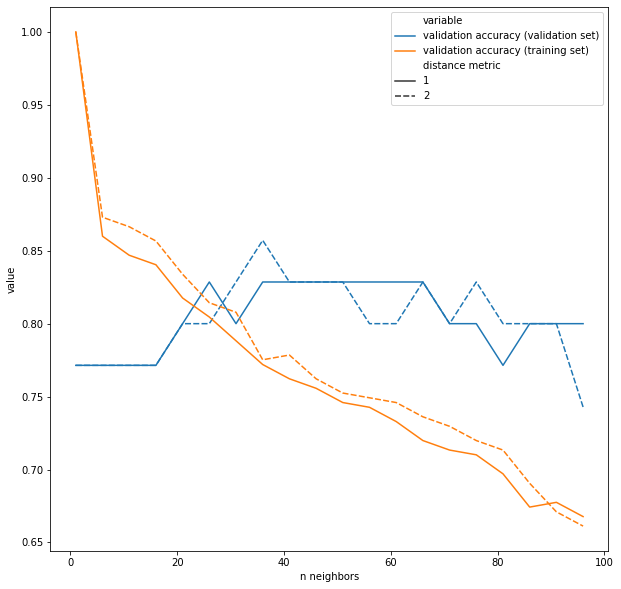

In [4]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.lineplot(x='n neighbors', y='value',
             hue='variable', style="distance metric",  data = pd.melt(scores_df, ['n neighbors', 'distance metric']), 
             err_style=None, ax=ax)

In [5]:
# The best configuration:
scores_df.sort_values(by='validation accuracy (validation set)', ascending=False).head(1)

,n neighbors,distance metric,validation accuracy (validation set),validation accuracy (training set)
15,36,2,0.857143,0.775244


In [6]:
top_n= scores_df.sort_values(by='validation accuracy (validation set)', ascending=False).head(1)
top_p =  int(top_n.iloc[0]['distance metric'])
top_n =  int(top_n.iloc[0]['n neighbors'])


### The validation accuracy seems to grow as the train validation decline. This migh happens since the sample of data is to small and the validation set isn't representing very well the train set. <br> We can use a crossvalidation with K-fold of 5 and see if this changes

In [7]:
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

#Split in train and test
f_tr, f_te, c_tr, c_te = train_test_split(
    features, spec, test_size=0.3, stratify=spec, random_state=1)

# Create k-fold object
kfold = StratifiedKFold(n_splits=5)

k_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])

# Define the set of values we will iterate
k_values = np.arange(1, 100,5) 
d_types = [1,2] # L1 and L2 distance


grid_knn = GridSearchCV(k_pipe, [{
    'knn__n_neighbors': k_values,
    'knn__p': d_types
}], cv=kfold)


grid_knn.fit(f_tr, c_tr)

# Collect results in a DataFrame
knn_crossvalidated = pd.DataFrame.from_items([
    ('n_neighbors', grid_knn.cv_results_['param_knn__n_neighbors']),
    ('distance metric', grid_knn.cv_results_['param_knn__p']),
    ('mean', grid_knn.cv_results_['mean_test_score']),
    ('std', grid_knn.cv_results_['std_test_score'])
])
knn_crossvalidated.sort_values(by='mean', ascending=False).head(10)

/Users/pancho/opt/anaconda3/envs/capstone-project/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,n_neighbors,distance metric,mean,std
5,11,2,0.812865,0.027419
3,6,2,0.804094,0.025148
7,16,2,0.798246,0.023084
2,6,1,0.789474,0.054093
4,11,1,0.786550,0.032371
6,16,1,0.786550,0.031463
13,31,2,0.780702,0.042524
9,21,2,0.780702,0.022613
8,21,1,0.777778,0.027346
1,1,2,0.777778,0.054312


In [8]:
top_n= knn_crossvalidated.sort_values(by='mean', ascending=False).head(1)
top_p =  int(top_n.iloc[0]['distance metric'])
top_n =  int(top_n.iloc[0]['n_neighbors'])

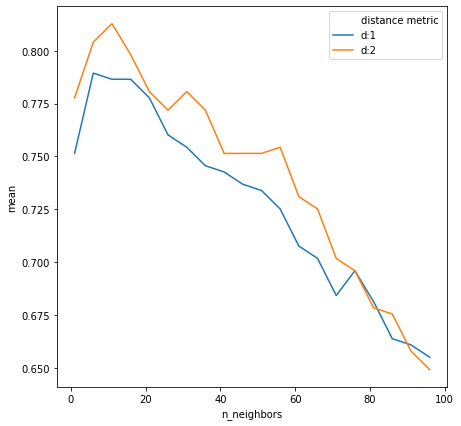

In [9]:
knn_crossvalidated['distance metric'] = knn_crossvalidated['distance metric'].replace({1:'d:1', 2:'d:2'})

fig, ax = plt.subplots(1,1, figsize=(7,7))
sns.lineplot(x='n_neighbors', y='mean',
             hue='distance metric', data = knn_crossvalidated, 
             err_style=None, ax=ax)

### With cross-validation we reduced the problem and we have a curve that reduces the mean as the n of neighbors increases

## Now we use the whole train data set and Test

In [20]:
f_tr, f_te, c_tr, c_te = train_test_split(
    features, spec, test_size=0.3, stratify=spec, random_state=1)

pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier(n_neighbors = top_n, p=top_p))
])

# Fit to train data
pipe.fit(f_tr, c_tr)

# Evaluate on test set
accuracy = pipe.score(f_te, c_te)
print('k-NN Accuracy (Test set): {:.3f}%'.format(accuracy * 100))

k-NN Accuracy (Test set): 83.673%
